# <strong>YZV 202E - OPTIMIZATION FOR DATA SCIENCE PROJECT</strong>
# Importance of Optimization Techniques in Post-Earthquake Relief

## Team: Iron-Flag
## Team Members: Mustafa Bayrak, Zehra Demir

Install necessary packages

In [47]:
pip install basemap

Note: you may need to restart the kernel to use updated packages.


In [48]:
pip install geopy

Note: you may need to restart the kernel to use updated packages.


### Importing the necessary libraries

In [49]:
import pandas as pd
import numpy as np
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import random
from geopy.geocoders import Nominatim

### Reading the Excel file that contains populations and information of whether they are affected city or distribution city

In [50]:
df = pd.read_excel("../Datasets/excel/cities.xlsx")

### First 15 cities in the dataframe (descending order)

In [51]:
df.head(15)

,Name,Affected,Dist,Population
0,İstanbul,0,1,15462452
1,Ankara,0,1,5663322
2,İzmir,0,1,4394694
3,Bursa,0,1,3101833
4,Antalya,0,1,2548308
5,Adana,1,0,2258718
6,Konya,0,1,2250020
7,Şanlıurfa,1,0,2115256
8,Gaziantep,1,0,2101157
9,Kocaeli,0,1,1997258


### Load Arrays of distribution centers and affected cities

In [52]:
dist_centers = np.load('../Datasets/numpy-arrays/dist_cities.npy')
affected_cities = np.load('../Datasets/numpy-arrays/affected_cities.npy')

### Names of distribution centers

In [53]:
dist_centers

array(['İstanbul', 'Ankara', 'İzmir', 'Bursa', 'Antalya', 'Konya',
       'Kocaeli', 'Mersin', 'Manisa', 'Kayseri'], dtype='<U8')

### Names of the affected cities

In [54]:
affected_cities

array(['Adana', 'Şanlıurfa', 'Gaziantep', 'Diyarbakır', 'Hatay',
       'Kahramanmaraş', 'Malatya', 'Adıyaman', 'Elazığ', 'Osmaniye',
       'Kilis'], dtype='<U13')

### Creating the distances matrix

In [55]:
distances = pd.read_excel("../Datasets/excel/ilmesafe.xlsx")

In [56]:
distances

,Name,Adana,Adıyaman,Afyonkarahisar,Ağrı,Amasya,Ankara,Antalya,Artvin,Aydın,...,Batman,Şırnak,Bartın,Ardahan,Iğdır,Yalova,Karabük,Kilis,Osmaniye,Düzce
0,Adana,NaN,337.0,578.0,973.0,603.0,492.0,547.0,1001.0,880.0,...,628.0,712.0,784.0,1037.0,1077.0,905.0,714.0,251.0,89.0,735.0
1,Adıyaman,337.0,NaN,915.0,642.0,627.0,732.0,884.0,715.0,1217.0,...,297.0,464.0,1016.0,751.0,746.0,1137.0,946.0,210.0,244.0,966.0
2,Afyonkarahisar,578.0,915.0,NaN,1320.0,596.0,255.0,287.0,1224.0,340.0,...,1207.0,1290.0,518.0,1361.0,1464.0,346.0,449.0,830.0,667.0,371.0
3,Ağrı,973.0,642.0,1320.0,NaN,740.0,1055.0,1424.0,364.0,1634.0,...,365.0,424.0,1171.0,305.0,144.0,1363.0,1106.0,812.0,880.0,1192.0
4,Amasya,603.0,627.0,596.0,740.0,NaN,331.0,823.0,679.0,935.0,...,805.0,998.0,436.0,781.0,884.0,629.0,371.0,640.0,603.0,458.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,Yalova,905.0,1137.0,346.0,1363.0,629.0,407.0,610.0,1238.0,507.0,...,1403.0,1549.0,373.0,1347.0,1507.0,NaN,351.0,1116.0,994.0,171.0
77,Karabük,714.0,946.0,449.0,1106.0,371.0,216.0,735.0,958.0,788.0,...,1174.0,1358.0,86.0,1067.0,1250.0,351.0,NaN,925.0,803.0,180.0
78,Kilis,251.0,210.0,830.0,812.0,640.0,711.0,798.0,885.0,1131.0,...,467.0,550.0,995.0,920.0,915.0,1116.0,925.0,NaN,159.0,945.0
79,Osmaniye,89.0,244.0,667.0,880.0,603.0,581.0,636.0,909.0,969.0,...,535.0,619.0,873.0,944.0,984.0,994.0,803.0,159.0,NaN,823.0


Create a new dataframe containing distribution cities in rows

In [57]:
new_df = pd.DataFrame(columns=distances.columns)

# Iterate over each row in the original dataframe
for index, row in distances.iterrows():
    if row['Name'] in dist_centers:
        # Append the row to the new dataframe
        new_df = pd.concat([new_df, row.to_frame().T])

# Reset the index of the new dataframe
new_df.reset_index(drop=True, inplace=True)

### Distances between distribution centers to each affected city

In [58]:
distance_df = new_df[affected_cities]

In [59]:
distance_df

,Adana,Şanlıurfa,Gaziantep,Diyarbakır,Hatay,Kahramanmaraş,Malatya,Adıyaman,Elazığ,Osmaniye,Kilis
0,492.0,786.0,647.0,898.0,688.0,572.0,652.0,732.0,749.0,581.0,711.0
1,547.0,902.0,763.0,1084.0,743.0,744.0,953.0,884.0,1051.0,636.0,798.0
2,856.0,1158.0,1020.0,1270.0,1052.0,944.0,1024.0,1104.0,1121.0,945.0,1083.0
3,70.0,424.0,286.0,606.0,265.0,267.0,466.0,407.0,564.0,159.0,321.0
4,951.0,1237.0,1098.0,1349.0,1147.0,1023.0,1103.0,1183.0,1200.0,1040.0,1162.0
5,907.0,1261.0,1123.0,1436.0,1102.0,1104.0,1190.0,1244.0,1287.0,995.0,1158.0
6,335.0,468.0,330.0,581.0,428.0,255.0,335.0,414.0,432.0,356.0,393.0
7,840.0,1127.0,988.0,1239.0,1036.0,913.0,993.0,1072.0,1090.0,929.0,1051.0
8,357.0,712.0,573.0,887.0,553.0,555.0,641.0,695.0,738.0,446.0,609.0
9,886.0,1240.0,1102.0,1415.0,1081.0,1083.0,1169.0,1223.0,1266.0,974.0,1137.0


In [60]:
distance_matrix = np.array(distance_df)

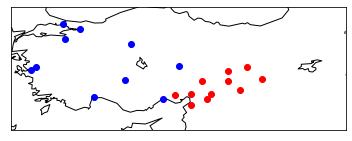

In [61]:
# Geocoding setup
geolocator = Nominatim(user_agent="my-app")

# Map setup
map = Basemap(llcrnrlon=26, llcrnrlat=35, urcrnrlon=45, urcrnrlat=42, resolution='l')
map.drawcoastlines()

# Plot red cities
for city in dist_centers:
    location = geolocator.geocode(city + ", Turkey")
    lon, lat = location.longitude, location.latitude
    x, y = map(lon, lat)
    map.plot(x, y, 'bo')

# Plot blue cities
for city in affected_cities:
    location = geolocator.geocode(city + ", Turkey")
    lon, lat = location.longitude, location.latitude
    x, y = map(lon, lat)
    map.plot(x, y, 'ro')

# Show the map
plt.show()

## Fixed Values

In [62]:
MAX_HELICOPTER_CAPACITY = 20
HELICOPTER_SPEED = 200
MAX_TRUCK_CAPACITY = 50
TRUCK_SPEED = 100
HELICOPTER_NUMBER = 10
TRUCK_NUMBER = 500
NUM_DISTRIBUTION_CENTERS = 10
NUM_AFFECTED_CITIES = 11

### Supplies and demands are proportional with population

In [63]:
supplies = np.load('../Datasets/numpy-arrays/supplies.npy')

demands = np.load('../Datasets/numpy-arrays/demands.npy')

In [64]:
sum(supplies)

9031

In [65]:
sum(demands)

9013

In [66]:
max_helicopter = np.load('../Datasets/numpy-arrays/max_helicopter.npy')

In [67]:
max_truck = np.load('../Datasets/numpy-arrays/max_truck.npy')

# Genetic Algorithm

### Creating the Population

In [68]:
def create_population(size, max_truck, max_helicopter, supplies, demands):
    population = []
    for _ in range(size):
        # Copy maximum capacities
        remaining_truck = max_truck.copy()
        remaining_helicopter = max_helicopter.copy()
        
        # Shuffle the order of indices for i and j
        indices_i = list(range(10))
        indices_j = list(range(11))
        
        # Shuffle the order of indices again for i and j
        random.shuffle(indices_i)
        random.shuffle(indices_j)

        # Create a 2D list for truck transfers with random values
        truck_transfers = np.zeros((10, 11), dtype=int)
        for i in indices_i:
            for j in indices_j:
                # Maximum transfer allowed is the lesser of remaining supply, demand, and remaining truck capacity
                max_transfer = min(supplies[i], demands[j], remaining_truck[i])  
                truck_transfer = np.random.randint(0, max_transfer + 1)
                truck_transfers[i][j] = truck_transfer
                # Decrease remaining truck capacity
                remaining_truck[i] -= truck_transfer
                
        random.shuffle(indices_i)
        random.shuffle(indices_j)
        
        # Create a 2D list for helicopter transfers based on truck transfers
        helicopter_transfers = np.zeros((10, 11), dtype=int)
        for i in indices_i:
            for j in indices_j:
                # Maximum transfer allowed is the lesser of remaining supply, remaining demand, and remaining helicopter capacity
                remaining_supply = supplies[i] - truck_transfers[i][j]
                remaining_demand = demands[j] - truck_transfers[i][j]
                max_transfer = min(remaining_supply, remaining_demand, remaining_helicopter[i])  
                helicopter_transfer = np.random.randint(0, max_transfer + 1)  # Generate random helicopter transfer
                helicopter_transfers[i][j] = helicopter_transfer
                # Decrease remaining helicopter capacity
                remaining_helicopter[i] -= helicopter_transfer
        individual = [
            truck_transfers,
            helicopter_transfers
        ]
        population.append(individual)
    return population

### Fitness Function

In [69]:
def fitness_function(individual):
    truck_transfers = np.array(individual[0])
    helicopter_transfers = np.array(individual[1])
    total_cost = np.sum(distance_matrix * (helicopter_transfers / HELICOPTER_SPEED))\
    + np.sum(distance_matrix * (truck_transfers / TRUCK_SPEED))
    penalty = 0
    for i in range(len(supplies)):
        if (sum(truck_transfers[i]) + sum(helicopter_transfers[i])) > supplies[i] * 1.2:
            penalty +=1
        elif sum(truck_transfers[i]) > max_truck[i] *1.2\
        or sum(helicopter_transfers[i]) > max_helicopter[i] *1.2:
            penalty +=1
    total_cost += 1e6 *penalty
    return -total_cost

### Selection

In [70]:
def selection(population, num_parents, fitnesses):
    # calculate total fitness of all individuals
    total_fitness = sum(fitnesses)
    # calculate relative fitness of each individual
    rel_fitness = [f/total_fitness for f in fitnesses]
    # generate probability intervals for each individual
    probs = [sum(rel_fitness[:i+1]) for i in range(len(rel_fitness))]
    # draw new population
    new_population = []
    for n in range(num_parents):
        r = random.random()
        for (i, individual) in enumerate(population):
            if r <= probs[i]:
                new_population.append(individual)
                break
    return new_population

### Crossover

In [71]:
def uniform_crossover(parent1, parent2):
    # Define a crossover rate
    crossover_rate = 0.5

    # Perform uniform crossover
    child1_truck = []
    child2_truck = []
    child1_heli = []
    child2_heli = []

    # Crossover for truck transfers
    for i in range(len(parent1[0])):
        if np.random.random() < crossover_rate:
            child1_truck.append(parent1[0][i])
            child2_truck.append(parent2[0][i])
        else:
            child1_truck.append(parent2[0][i])
            child2_truck.append(parent1[0][i])

    # Crossover for helicopter transfers
    for i in range(len(parent1[1])):
        if np.random.random() < crossover_rate:
            child1_heli.append(parent1[1][i])
            child2_heli.append(parent2[1][i])
        else:
            child1_heli.append(parent2[1][i])
            child2_heli.append(parent1[1][i])
    
    return [np.array(child1_truck), np.array(child1_heli)], [np.array(child2_truck), np.array(child2_heli)]

### Mutation

In [72]:
def mutation(individual, mutation_rate, max_truck, max_helicopter, supplies, demands):
    truck_transfers, helicopter_transfers = individual

    for i in range(10):
        for j in range(11):
            if np.random.rand() < mutation_rate:
                    truck_transfers[i][j] += np.random.randint(0,3)
                    helicopter_transfers[i][j] += np.random.randint(0,3)

    return [truck_transfers, helicopter_transfers]

### Implementation of the Algorithm

In [ ]:
def genetic_algorithm(population_size=100, num_generations=200, mutation_rate=0.01):
    # Create initial population
    population = create_population(population_size, max_truck, max_helicopter, supplies, demands)
    
    # Evaluate the population
    fitness_values = [fitness_function(individual) for individual in population]

    # Iterate through each generation
    for generation in range(num_generations):

        # Create a new population
        new_population = []

        while len(new_population) < population_size:
            # Select two parents
            parent1, parent2 = selection(population, 2, fitness_values)
            
            # Create two children by crossover
            child1, child2 = uniform_crossover(parent1, parent2)

            # Add the children to the new population
            new_population += [child1, child2]

        # Apply mutation
        new_population = [mutation(individual, mutation_rate, max_truck, max_helicopter, supplies, demands) for individual in new_population]

        # Replace the old population with the new population
        population = new_population

        # Evaluate the new population
        fitness_values = [fitness_function(individual) for individual in population]
        
    # Return the individual with the best fitness value
    best_fitness_index = np.argmax(fitness_values)
    best_individual = population[best_fitness_index]

    return best_individual



population_size = 1000
num_generations = 200
mutation_rate = 0.01

best_individual = genetic_algorithm(population_size, num_generations, mutation_rate)

## Results of Genetic Algorithm

In [ ]:
print("Best Individual(Truck):\n", best_individual[0],"\n")
print("Best Individual(Helicopter):\n", best_individual[1])
print("Best Fitness:", -fitness_function(best_individual))

In [ ]:
supplies

In [ ]:
sum(best_individual[0][0])

In [ ]:
sum(best_individual[1][0])

In [ ]:
max_truck

In [ ]:
max_helicopter

# Simulated Annealing Algorithm

### Creating the Population

In [ ]:
def create_population(size, max_truck, max_helicopter, supplies, demands):
    population = []
    for _ in range(size):
        # Copy maximum capacities
        remaining_truck = max_truck.copy()
        remaining_helicopter = max_helicopter.copy()
        
        # Shuffle the order of indices for i and j
        indices_i = list(range(10))
        indices_j = list(range(11))
        
        # Shuffle the order of indices again for i and j
        random.shuffle(indices_i)
        random.shuffle(indices_j)

        # Create a 2D list for truck transfers with random values
        truck_transfers = np.zeros((10, 11), dtype=int)
        for i in indices_i:
            for j in indices_j:
                # Maximum transfer allowed is the lesser of remaining supply, demand, and remaining truck capacity
                max_transfer = min(supplies[i], demands[j], remaining_truck[i])  
                truck_transfer = np.random.randint(0, max_transfer + 1)
                truck_transfers[i][j] = truck_transfer
                # Decrease remaining truck capacity
                remaining_truck[i] -= truck_transfer
                
        random.shuffle(indices_i)
        random.shuffle(indices_j)
        
        # Create a 2D list for helicopter transfers based on truck transfers
        helicopter_transfers = np.zeros((10, 11), dtype=int)
        for i in indices_i:
            for j in indices_j:
                # Maximum transfer allowed is the lesser of remaining supply, remaining demand, and remaining helicopter capacity
                remaining_supply = supplies[i] - truck_transfers[i][j]
                remaining_demand = demands[j] - truck_transfers[i][j]
                max_transfer = min(remaining_supply, remaining_demand, remaining_helicopter[i])  
                helicopter_transfer = np.random.randint(0, max_transfer + 1)  # Generate random helicopter transfer
                helicopter_transfers[i][j] = helicopter_transfer
                # Decrease remaining helicopter capacity
                remaining_helicopter[i] -= helicopter_transfer
        individual = [
            truck_transfers,
            helicopter_transfers
        ]
        population.append(individual)
    return population

### Fitness Function

In [ ]:
def fitness_function(individual):
    truck_transfers = np.array(individual[0])
    helicopter_transfers = np.array(individual[1])
    total_cost = np.sum(distance_matrix * (helicopter_transfers / HELICOPTER_SPEED))\
    + np.sum(distance_matrix * (truck_transfers / TRUCK_SPEED))
    penalty = 0
    for i in range(len(supplies)):
        if (sum(truck_transfers[i]) + sum(helicopter_transfers[i])) > supplies[i] * 1.2:
            penalty +=1
        elif sum(truck_transfers[i]) > max_truck[i] *1.2\
        or sum(helicopter_transfers[i]) > max_helicopter[i] *1.2:
            penalty +=1
    total_cost += 1e6 *penalty
    return -total_cost

In [ ]:
def random_neighbor(individual, max_truck, max_helicopter, supplies, demands):
    truck_transfers, helicopter_transfers = individual
    
    # Shuffle the order of indices for i and j
    indices_i = list(range(10))
    indices_j = list(range(11))
        
    # Shuffle the order of indices again for i and j
    random.shuffle(indices_i)
    random.shuffle(indices_j)
    
    for i in indices_i:
        for j in indices_j:
            if sum(truck_transfers[i]) >= max_truck[i]:
                if random.random() < 0.5:
                    truck_transfers[i][j] -= np.random.randint(0, 60)
                    if truck_transfers[i][j] < 0:
                        truck_transfers[i][j] = 0
            else:
                truck_transfers[i][j] += np.random.randint(-2, 10)
                if truck_transfers[i][j] < 0:
                    truck_transfers[i][j] = 0 
            if sum(helicopter_transfers[i]) >= max_helicopter[i]:
                if random.random() < 0.5:
                    helicopter_transfers[i][j] -= np.random.randint(0, 60)
                    if helicopter_transfers[i][j] < 0:
                        helicopter_transfers[i][j] = 0
            else:
                helicopter_transfers[i][j] += np.random.randint(-2, 10)
                if helicopter_transfers[i][j] < 0:
                        helicopter_transfers[i][j] = 0 

    # Check if the new solution exceeds capacity limits
    for i in range(len(supplies)):
        if (sum(truck_transfers[i]) + sum(helicopter_transfers[i])) > supplies[i] * 1.2 \
                or sum(truck_transfers[i]) > max_truck[i] \
                or sum(helicopter_transfers[i]) > max_helicopter[i]:
            return individual  # Return the original solution if the new solution exceeds capacity limits

    return [truck_transfers, helicopter_transfers]

### Probability

In [ ]:
def acceptance_probability(energy, new_energy, temperature):
    if new_energy < energy:
        return 1.0
    return np.exp((energy - new_energy) / temperature)

### Implementation of the Algorithm

In [ ]:
def simulated_annealing(initial_solution, max_truck, max_helicopter, supplies, demands, num_iterations, max_temperature):
    current_solution = initial_solution
    best_solution = initial_solution
    current_fitness = fitness_function(current_solution)
    best_fitness = current_fitness

    for iteration in range(num_iterations):
        temperature = max_temperature * (1 - iteration / num_iterations)  # Cooling schedule

        new_solution = random_neighbor(current_solution, max_truck, max_helicopter, supplies, demands)
        new_fitness = fitness_function(new_solution)

        if acceptance_probability(current_fitness, new_fitness, temperature) > random.random():
            current_solution = new_solution
            current_fitness = new_fitness

        if new_fitness > best_fitness:
            best_solution = new_solution
            best_fitness = new_fitness

    return best_solution

In [ ]:
population_size = 1000
initial_solution = create_population(population_size, max_truck, max_helicopter, supplies, demands)[0]
num_iterations = 1000
max_temperature = 10

best_individual = simulated_annealing(initial_solution, max_truck, max_helicopter, supplies, demands,
                                     num_iterations, max_temperature)

## Results

In [ ]:
print("Best Individual (Truck):\n", best_individual[0], "\n")
print("Best Individual (Helicopter):\n", best_individual[1])
print("Best Fitness:", -fitness_function(best_individual))